# Transformers. Перекладач

---
<a name="0" a/>

### Зміст:

* [Варіант 1. Pipeline](#1)
* [Варіант 2. Використання готової моделі з можливістю налаштування](#2)
* [Варіант 3. LSTM](#3)

Інсталяція бібліотек

In [ ]:
!pip install transformers datasets evaluate sacrebleu tensorflow

Імпорт бібліотек

In [15]:
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
from datasets import load_dataset

import string
import re
from numpy import array, argmax, random, take, linspace
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt

Налаштування

In [16]:
%matplotlib inline
pd.set_option('display.max_colwidth', 20)

---
<a name="1" a/>

### Варіант 1. Pipeline

[зміст](#0)

Це найпростіший варіант для використання. Імпортуємо з бібліотеки transformer - pipeline, створимо pipeline `translation` на основі моделі `t5-base`

In [3]:
translator = pipeline("translation", model="t5-base")

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/__init__.py:967: UserWarning: "translation" task was used, instead of "translation_XX_to_YY", defaulting to "translation_en_to_de"
  warnings.warn(


Створимо невеликий словничок з префіксними фразами тих мов, що є в моделі t5-base.

In [4]:
prefixes = {'en-fr': 'translate English to French:',
            'en-rm': 'translate English to Romanian:',
            'en-gr': 'translate English to German:'}

Створимо функцію перекладу, будемо подавати в неї фразу для перекладу та вказувати з якої та на яку мов перекладати.

In [5]:
def translate_multilanguage_pipeline(text, lang):
    prefix = prefixes[lang]

    print(translator(prefix + text))

Переклад з англійської на фрацузьку

In [6]:
translate_multilanguage_pipeline('Hello, how are you?', 'en-fr')

[{'translation_text': 'Bonjour, comment êtes-vous?'}]


Переклад з англійської на румунську

In [7]:
translate_multilanguage_pipeline('Hello, how are you?', 'en-rm')

[{'translation_text': 'Salut, cum sunteți?'}]


Переклад з англійської на німецьку

In [8]:
translate_multilanguage_pipeline('Hello, how are you?', 'en-gr')

[{'translation_text': 'Hallo, wie sind Sie?'}]


---
<a name="2" a/>

### Варіант 2. Використання готової моделі з можливістю налаштування
[зміст](#0)

In [10]:
tokenizer = AutoTokenizer.from_pretrained("t5-base")
model = TFAutoModelForSeq2SeqLM.from_pretrained("t5-base")

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Створимо таку ж функцію перекладу

In [11]:
def translate_multilanguage(text, lang):

    prefix = prefixes[lang]

    inputs = tokenizer.encode((prefix + text), return_tensors='pt')

    outputs = model.generate(inputs, max_length=40, num_beams=4, early_stopping=True)

    translated_text = tokenizer.decode(outputs[0])

    print(translated_text)

Переклад з англійської на фрацузьку

In [12]:
translate_multilanguage('Hello, how are you?', 'en-fr')

<pad> Bonjour, comment êtes-vous?</s><pad><pad>


Переклад з англійської на румунську

In [13]:
translate_multilanguage('Hello, how are you?', 'en-rm')

<pad> Salut, cum sunteți?</s><pad><pad>


Переклад з англійської на німецьку

In [14]:
translate_multilanguage('Hello, how are you?', 'en-gr')

<pad> Hallo, wie sind Sie?</s><pad><pad>


---
<a name="3" a/>

### Варіант 3. LSTM
[зміст](#0)

Завантажимо dataset:`opus100`, subset:`en-uk`. Використаємо для навчання для початку validation модель, щоб було швидше.

In [17]:
data = load_dataset("opus100", 'en-uk', split="train")
data = data['translation']

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Підготуємо данні. Створимо функцію розділу. Використаємо лише `50К` записів, бо датасет завеликий.

In [18]:
lim_sent = 50000

def split_text(text):
    i = 0
    df = pd.DataFrame(columns=['eng', 'ukr'])
    for line in text:
        if i < lim_sent:
            eng_text = line['en']
            eng_text = eng_text.strip().replace('.','').replace(',','').replace(':','').replace('?','').replace('!','').replace('-','').lower()

            ukr_text = line['uk']
            ukr_text = ukr_text.strip().replace('.','').replace(',','').replace(':','').replace('?','').replace('!','').replace('-','').lower()
            df.loc[len(df.index)] = [eng_text, ukr_text]
        i += 1
    return df

In [19]:
eng_ukr = split_text(data)
#eng_ukr = array(eng_ukr)

In [20]:
eng_ukr.shape

(50000, 2)

In [21]:
eng_ukr.head(10)

,eng,ukr
0,consistant with ...,как и все осталь...
1,the children,діти
2,i still have som...,в мене все ще є ...
3,anything else yo...,ви можете щось д...
4,successfully mov...,успішно пересуну...
5,the given name c...,не вдається зв' ...
6,jake your mom's ...,джейк твоя мама ...
7,father no,отецнет
8,data tool,засоби роботи з ...
9,shh shh shh shh,


---

## Перетворення тексту на послідовість

Виздачаємо оптимальну довжину речень

In [22]:
# Порожні списки
eng_l = []
urk_l = []

In [23]:
# Заповнюємо списки довжинами речень
for i in eng_ukr['eng']:
      eng_l.append(len(i.split()))

for i in eng_ukr['ukr']:
      urk_l.append(len(i.split()))

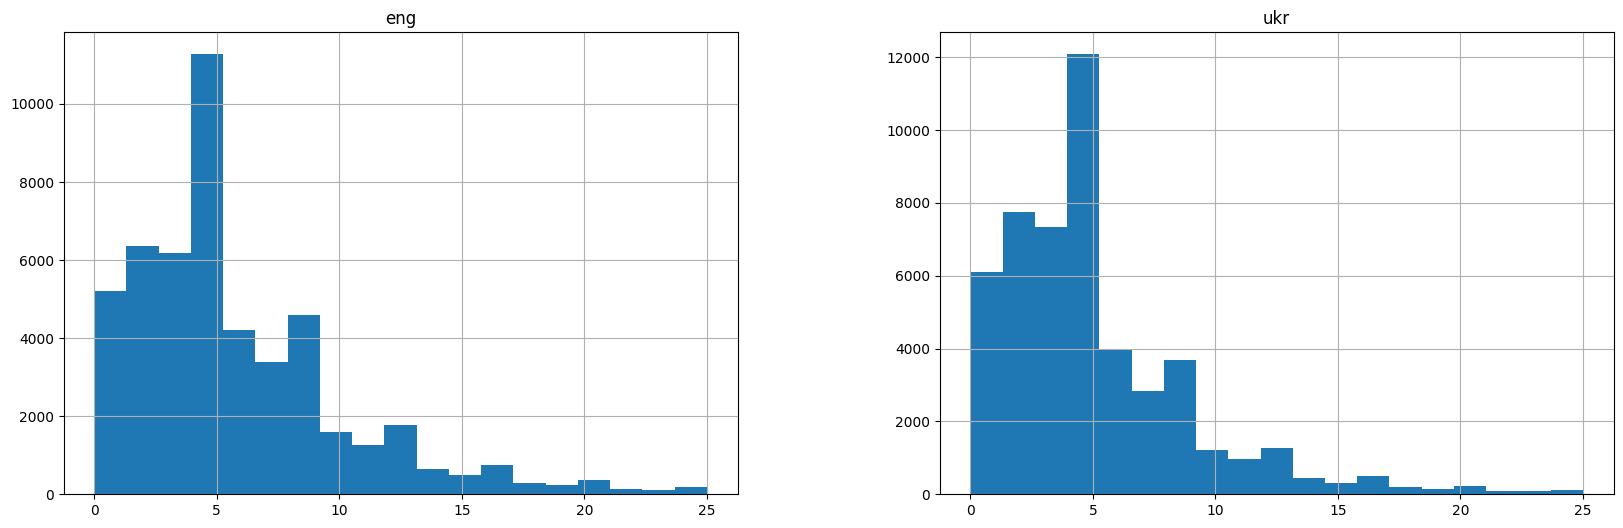

In [24]:
length_df = pd.DataFrame({'eng':eng_l, 'ukr':urk_l})

length_df.hist(bins = linspace(0, 25, 20), figsize = (20,6))

plt.show()

Виходячи з графіку росподілу бачимо що максимальна довжина речення (якщо нехтувати викидами) приблизно 21 слів для англійської та 18 слів для української.

Використаємо Keras Tokenizer для створеня послідовностей. Це перетворить наші речення на послідовність цілих чисел.

In [25]:
# функція для створення токенізатора
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [26]:
# підготовка токенізера англійської мови
eng_tokenizer = tokenization(eng_ukr['eng'])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 21
print('Розмір словника англійської мови: %d' % eng_vocab_size)

Розмір словника англійської мови: 23041


In [27]:
# підготовка токенізера української мови
ukr_tokenizer = tokenization(eng_ukr['ukr'])
ukr_vocab_size = len(ukr_tokenizer.word_index) + 1

ukr_length = 18
print('Розмір словника української мови: %d' % ukr_vocab_size)

Розмір словника української мови: 53097


Створимо функцію кодування та доповнення послідовностей.

In [28]:
def encode_sequences(tokenizer, length, lines):
         # цілочисельне кодування послідовностей
         seq = tokenizer.texts_to_sequences(lines)
         # заповнення послідовностей із значеннями 0
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

---

## Створення моделі

Розділимо набір данних на train та test. Візьмемо невиличку тестову частину щоб не перегружати декодер.

In [35]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(eng_ukr, test_size=0.001, random_state = 13)

In [36]:
test.size

100

Кодуємо послідовності. Англійськи речення - як вхідні послідовності, українські - як цільові.

In [37]:
# для навчальних данних
trainX = encode_sequences(eng_tokenizer, eng_length, train['eng'])
trainY = encode_sequences(ukr_tokenizer, ukr_length, train['ukr'])

# для тестових данних
testX = encode_sequences(eng_tokenizer, eng_length, test['eng'])
testY = encode_sequences(ukr_tokenizer, ukr_length, test['ukr'])

Функція створення моделі. Архітектура моделі на зображенні:
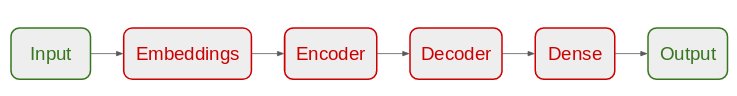

In [38]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

Компілюємо модель

In [39]:
model = define_model(eng_vocab_size, ukr_vocab_size, eng_length, ukr_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 512)           11796992  
                                                                 
 lstm (LSTM)                 (None, 512)               2099200   
                                                                 
 repeat_vector (RepeatVector  (None, 18, 512)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 18, 512)           2099200   
                                                                 
 dense (Dense)               (None, 18, 53097)         27238761  
                                                                 
Total params: 43,234,153
Trainable params: 43,234,153
Non-trainable params: 0
____________________________________________

Збережемо модель

In [41]:
filename = 'model.eng_ukr.3'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Навчаємо модель

In [42]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=10, batch_size=512, validation_split = 0.2,callbacks=[checkpoint],
                    verbose=1)

Epoch 1/10
79/79 [==============================] - ETA: 0s - loss: 3.9614
Epoch 1: val_loss improved from inf to 3.06258, saving model to model.eng_ukr.3


79/79 [==============================] - 121s 1s/step - loss: 3.9614 - val_loss: 3.0626
Epoch 2/10
79/79 [==============================] - ETA: 0s - loss: 2.8287
Epoch 2: val_loss improved from 3.06258 to 2.74506, saving model to model.eng_ukr.3


79/79 [==============================] - 84s 1s/step - loss: 2.8287 - val_loss: 2.7451
Epoch 3/10
79/79 [==============================] - ETA: 0s - loss: 2.7287
Epoch 3: val_loss improved from 2.74506 to 2.68889, saving model to model.eng_ukr.3


79/79 [==============================] - 76s 967ms/step - loss: 2.7287 - val_loss: 2.6889
Epoch 4/10
79/79 [==============================] - ETA: 0s - loss: 2.6741
Epoch 4: val_loss improved from 2.68889 to 2.68015, saving model to model.eng_ukr.3


79/79 [==============================] - 74s 944ms/step - loss: 2.6741 - val_loss: 2.6801
Epoch 5/10
79/79 [==============================] - ETA: 0s - loss: 2.6421
Epoch 5: val_loss improved from 2.68015 to 2.64439, saving model to model.eng_ukr.3


79/79 [==============================] - 76s 961ms/step - loss: 2.6421 - val_loss: 2.6444
Epoch 6/10
79/79 [==============================] - ETA: 0s - loss: 2.6188
Epoch 6: val_loss improved from 2.64439 to 2.63545, saving model to model.eng_ukr.3


79/79 [==============================] - 71s 907ms/step - loss: 2.6188 - val_loss: 2.6355
Epoch 7/10
79/79 [==============================] - ETA: 0s - loss: 2.6064
Epoch 7: val_loss improved from 2.63545 to 2.62511, saving model to model.eng_ukr.3


79/79 [==============================] - 73s 927ms/step - loss: 2.6064 - val_loss: 2.6251
Epoch 8/10
78/79 [============================>.] - ETA: 0s - loss: 2.5912
Epoch 8: val_loss did not improve from 2.62511
79/79 [==============================] - 58s 734ms/step - loss: 2.5911 - val_loss: 2.6629
Epoch 9/10
79/79 [==============================] - ETA: 0s - loss: 2.5813
Epoch 9: val_loss did not improve from 2.62511
79/79 [==============================] - 56s 711ms/step - loss: 2.5813 - val_loss: 2.6799
Epoch 10/10
78/79 [============================>.] - ETA: 0s - loss: 2.5739
Epoch 10: val_loss did not improve from 2.62511
79/79 [==============================] - 57s 718ms/step - loss: 2.5735 - val_loss: 2.6484


Побудуємо графік навчання

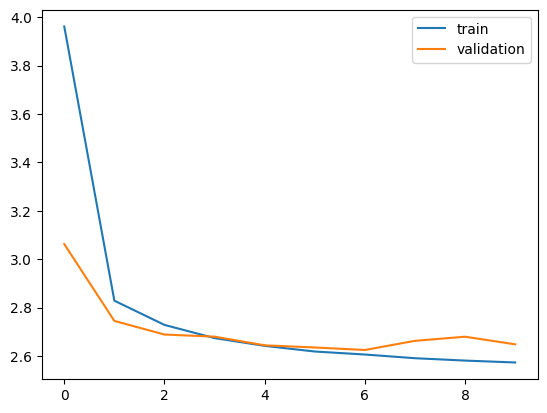

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Бачимо швидке падіння помилки вже на 1 епосі. Далі потроху зменьшується, стрибок на валідних данних на 8 епосі, потім знову зменьшення.

Завантажуємо збережену модель та робимо прогноз

In [44]:
model = load_model('model.eng_ukr.3')
# тут мало б бути
# preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))

2/2 [==============================] - 2s 22ms/step


In [45]:
classes_x = argmax(preds, axis=-1)

In [46]:
classes_x[0]

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Перетворимо послідовності чисел на відповідні їм слова. Підготуємо функцію

In [47]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [48]:
preds_text = []
for i in classes_x:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], ukr_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], ukr_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)
    preds_text.append(' '.join(temp))

Помістимо вихідні українські речення в тестовий набір даних, а прогнозовані речення — у фрейм даних

In [49]:
pred_df = pd.DataFrame({'actual' : test['ukr'], 'predicted' : preds_text})

Приклади

In [50]:
pred_df.sample(10)

,actual,predicted
6,джейк твоя мама ...,я
8832,она не будет сда...,я
32747,а якщо продовжиш...,я
17385,держись в двадца...,я
30440,тоді дій,я
48069,список шляхів до...,я
38583,а що ти їй скажеш,я
43547,мне так жаль,я
11815,це серйозно,я
7274,функції дати і ч...,я


Нажаль в пункті отримання predict метод predict_classes не працює, а його замінник argmax дає помилкову відповідь. В цьому пункті ще треба розібратісь. Саме тому переклад поганий.

### Дякую за увагу =)